In [1]:
#Gerekli Kütüphaneler
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
from itertools import chain
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve, train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score
import warnings
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
from matplotlib import animation
from matplotlib.patches import FancyArrowPatch
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler


warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('dataset1.csv')

In [3]:
#Daha iyi incelemek adına tüm datasetin sütun grafiğini oluşturyoruz
null_feat = pd.DataFrame(len(data['id']) - data.isnull().sum(), columns = ['Count'])

trace = go.Bar(x = null_feat.index, y = null_feat['Count'] ,opacity = 0.8, marker=dict(color = '#90c1d6',
        line=dict(color='#a3dfe3',width=1.5)))

layout = dict(title =  "Missing Values")

fig = dict(data = [trace], layout=layout)
py.iplot(fig)

In [4]:
#Unnamed: 32 coloumn Nan değeri olduğu için o sütunu siliyoruz.İleride sorun çıkartacaktır.
data = data.drop(['Unnamed: 32','id'],axis = 1)

#Hedef Atamaları yapılmıştır.M=1 B=0 Kötü huylu=1,iyi huylu=0
data.diagnosis.replace(to_replace = dict(M = 1, B = 0), inplace = True)

In [5]:
data = data.drop(['perimeter_mean', 'smoothness_mean','symmetry_mean', 'fractal_dimension_mean', 'smoothness_se', 'symmetry_se',
'fractal_dimension_se', 'smoothness_worst',
'symmetry_worst', 'fractal_dimension_worst'],axis = 1)

In [6]:
data.head()

,diagnosis,radius_mean,texture_mean,area_mean,compactness_mean,concavity_mean,concave points_mean,radius_se,texture_se,perimeter_se,...,compactness_se,concavity_se,concave points_se,radius_worst,texture_worst,perimeter_worst,area_worst,compactness_worst,concavity_worst,concave points_worst
0,1,17.99,10.38,1001.0,0.27760,0.3001,0.14710,1.0950,0.9053,8.589,...,0.04904,0.05373,0.01587,25.38,17.33,184.60,2019.0,0.6656,0.7119,0.2654
1,1,20.57,17.77,1326.0,0.07864,0.0869,0.07017,0.5435,0.7339,3.398,...,0.01308,0.01860,0.01340,24.99,23.41,158.80,1956.0,0.1866,0.2416,0.1860
2,1,19.69,21.25,1203.0,0.15990,0.1974,0.12790,0.7456,0.7869,4.585,...,0.04006,0.03832,0.02058,23.57,25.53,152.50,1709.0,0.4245,0.4504,0.2430
3,1,11.42,20.38,386.1,0.28390,0.2414,0.10520,0.4956,1.1560,3.445,...,0.07458,0.05661,0.01867,14.91,26.50,98.87,567.7,0.8663,0.6869,0.2575
4,1,20.29,14.34,1297.0,0.13280,0.1980,0.10430,0.7572,0.7813,5.438,...,0.02461,0.05688,0.01885,22.54,16.67,152.20,1575.0,0.2050,0.4000,0.1625


In [8]:
#Daha iyi incelemek adına tüm datasetin sütun grafiğini oluşturyoruz
null_feat = pd.DataFrame(len(data['diagnosis']) - data.isnull().sum(), columns = ['Count'])

trace = go.Bar(x = null_feat.index, y = null_feat['Count'] ,opacity = 0.8, marker=dict(color = '#90c1d6',
        line=dict(color='#a3dfe3',width=1.5)))

layout = dict(title =  "Missing Values")

fig = dict(data = [trace], layout=layout)
py.iplot(fig)

In [7]:
#corr(), veri çerçevesindeki tüm sütunların ikili korelasyonunu bulmak için kullanılır.
correlation = data.corr()
matrix_cols = correlation.columns.tolist()
#diziye çevirilmiştir
corr_array  = np.array(correlation)
trace = go.Heatmap(z = corr_array,
                   x = matrix_cols,
                   y = matrix_cols,
                   xgap = 2,
                   ygap = 2,
                   colorscale='Agsunset',
                   colorbar   = dict() ,
                  )
layout = go.Layout(dict(title = 'Correlation Matrix for variables',
                        autosize = False,
                        height  = 720,
                        width   = 800,
                        margin  = dict(r = 0 ,l = 210,
                                       t = 25,b = 210,
                                     ),
                        yaxis   = dict(tickfont = dict(size = 9)),
                        xaxis   = dict(tickfont = dict(size = 9)),
                       )
                  )
fig = go.Figure(data = [trace],layout = layout)
py.iplot(fig)

In [8]:
# X'e features , Y'ise diagnosis kolonlarının değerlerini bir değişkene atadık
X = data.iloc[:,1:].values
y = data['diagnosis'].values
#X,y = np.array(data.iloc[:,1:].values),np.array(data.iloc[:,0].values)

In [9]:
print(f"'X' shape: {X.shape}")
print(f"'y' shape: {y.shape}")

'X' shape: (569, 20)
'y' shape: (569,)


In [10]:
#Her Ml alogritması için gerekli kütüphaneler satırlarda import edilcektir.
## SVC sınıfını import ettik
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score,learning_curve, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [11]:
#Scikit-learn nesnesi MinMaxScaler'ı kullanarak veri kümenizi normalize edebilir, ölçekleme  yapabiliriz .
#Scikit-learn nesnesi StandardScaler'ı kullanarak veri kümenizi standartlaştırabilirsiniz .
pipeline = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('std_scaler', StandardScaler())
])
# Veri kümemizi test ve train şekinde bölüyoruz
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22,stratify=y)


In [12]:
#ÖZELLİK ÖLÇEKLENDİRME
#Destek Vektör Makinesi (SVM) optimizasyonu, w karar vektörü en aza indirilerek gerçekleştiğinden, optimum hiper düzlem, girdi özelliklerinin ölçeğinden etkilenir ve bu nedenle, SVM model eğitiminden önce verilerin standartlaştırılması  önerilir.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)

Text(0.5, 1.0, 'Support Vector Classifier scores for different kernels')

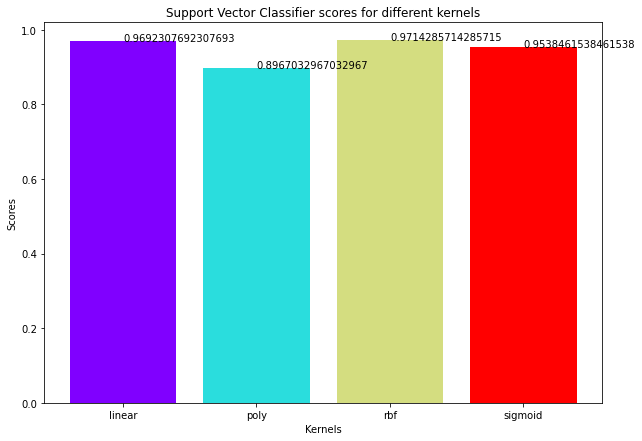

In [57]:
# SVC sınıfından bir nesne ürettik
# Parametre olarak farklı kernel trick tipleri verilebilir.
# Başarı oranının değiştiği gözlemlenecektir. ( ‘linear’, ‘poly’, ‘rbf’)
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
svc_scores = []
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
for i in range(len(kernels)):
    svc_classifier = SVC(kernel = kernels[i])
    pipe = make_pipeline(scaler,svc_classifier)
    svc_scores.append(cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy').mean())
from matplotlib.cm import rainbow
import numpy as np
colors = rainbow(np.linspace(0, 1, len(kernels)))
plt.figure(figsize=(10,7))
plt.bar(kernels, svc_scores, color = colors)
for i in range(len(kernels)):
    plt.text(i, svc_scores[i], svc_scores[i])
plt.xlabel('Kernels')
plt.ylabel('Scores')
plt.title('Support Vector Classifier scores for different kernels')

In [58]:
print('Accuracy score on Train data: {}'.format(svc_scores[2]*100))
from sklearn import metrics
svc_classifier = SVC(kernel = 'rbf')
pipe = make_pipeline(scaler,svc_classifier)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print('Accuracy score on Test data: {}'.format(metrics.accuracy_score(y_test,y_pred)*100))

Accuracy score on Train data: 97.14285714285715
Accuracy score on Test data: 97.36842105263158


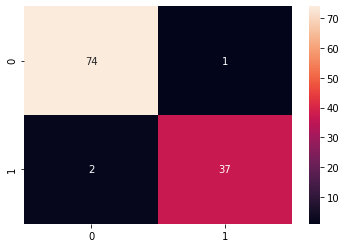

In [59]:
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt="d")

In [15]:
#Verileri normalleştirme
#Verileri, her grup bütünün küçük bir bölümünü tanımlayacak şekilde mantıksal gruplar halinde düzenleyin. 
#Bir veritabanında depolanan yinelenen verilerin miktarını en aza indirin.
norm_data = (X - np.min(X)) / (np.max(X) - np.min(X))   #Sadece X y alma 2 y almış olursun 

In [16]:
norm_data.shape

(569, 20)

In [17]:
#Train = 80%     Test = 20%
#from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(norm_data, y, test_size=0.2, random_state=102) #0.20 4
# 2 y değişkeni sen malmısın
print("x train: ",X_train.shape)
print("x test: ",X_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (455, 20)
x test:  (114, 20)
y train:  (455,)
y test:  (114,)


In [18]:
#Lojistik Regression uyguladık
from sklearn.linear_model import LogisticRegression
##Model Oluşturdum
lr = LogisticRegression(random_state=102,solver='lbfgs') 
# Eğitim modeli
lr.fit(X_train, y_train)
# Önemli metrikleri yakalayacağız
print(lr.classes_)
#print('Karar fonksiyonundaki özelliklerin katsayısı: ', lr.coef_)

[0 1]


In [19]:
#X_Test Seti ile Tahmin Yapmak
## Sadece y_pred'den oluşan df'e test(gerçek) y_test'i sütun olarak ekledim
predictions = lr.predict(X_test)
#Skor yazdırma
from sklearn.metrics import accuracy_score, roc_auc_score
accuracy_score = accuracy_score(predictions, y_test)
auc = roc_auc_score(y_test, predictions)
print('Lojistik Regression accuracy_score: {}  %'.format(accuracy_score*100))
#print('auc: {}  %'.format(auc*100))

Lojistik Regression accuracy_score: 91.22807017543859  %


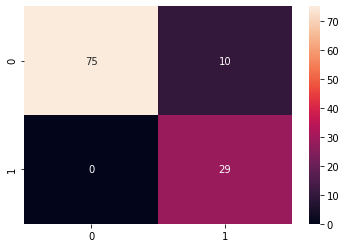

In [20]:
sns.heatmap(confusion_matrix(predictions, y_test), annot=True, fmt="d")

In [21]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import preprocessing

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
#ann modeli oluşturulmuştur.
#Keras iki modele sahiptir Sequential= doğrusal bir katman yığını(a linear stack of layers), ve Graf=katmanların yönlendirilmiş döngüsel olmayan grafiği.
#Sequential modeli kullandık
model = Sequential()
model.add(Dense(12, input_dim=20, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
#keras modelini çalıştırdık/derledik.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#keras modelini veri kümesine ayarladık
#train modülü için 3=devir,16 (örnek)grubu (3 epochs,batches of 16 samples) ile X_train dizisinde depolanan verilerde,y_train dizisinde depolanan etiketler
model.fit(X_train,y_train, epochs=150, batch_size=10, verbose=0)
#Başarı oranı yazdırıyoruz
predictions = model.predict_classes(X_test)
accuracy=accuracy_score(y_test, predictions)
print('ANN with keras Accuracy: %.2f' % (accuracy*100))
# summarize the first 5 cases
#for i in range(5):
    #print('%s => %d (expected %d)' % (X[i].tolist(), predictions[i], y[i]))

ANN with keras Accuracy: 94.74


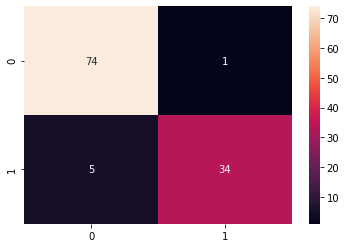

In [23]:
sns.heatmap(confusion_matrix(y_test,predictions), annot=True, fmt="d")

In [24]:
#Neural Networks(Multi Layer Perceptron)
from sklearn.neural_network import MLPClassifier

#Model oluşturlmuştur ve parametreler dahil edilmiştir.
model = MLPClassifier(hidden_layer_sizes = (200, 200), max_iter = 200)

# feeding the training set into the model
model.fit(X_train, y_train)

# X_test için tahmin
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f" % (accuracy * 100.0))

# Doğruluk hesaplanmıştır.
#print("Training accuracy :", model.score(X_train, y_train))
#print("Testing accuarcy :", model.score(X_test, y_test))


Accuracy: 95.61


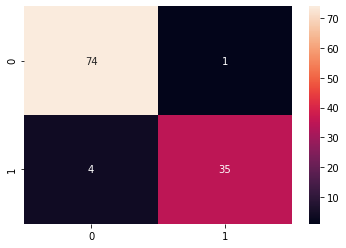

In [25]:
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt="d")

In [67]:
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import accuracy_score
#from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(norm_data, y, test_size=0.2, random_state=102) #0.20 4
nb = GaussianNB()
nb.fit(X_train, y_train)
predictions_nb = nb.predict(X_test)
accuracy_nb=accuracy_score(predictions_nb,y_test)
print("Accuracy: % {:10.2f}".format(accuracy_nb*100)) 
#print('Accuracy: %.2f' % (accuracy*100))
#print("Naive Bayes accuracy : {:.2f}%".format(nb.score(X_test, y_test)*100))

Accuracy: %      97.37


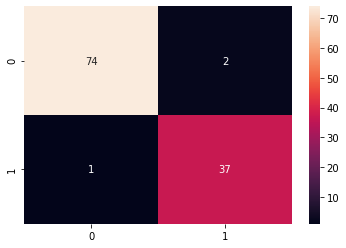

In [68]:
sns.heatmap(confusion_matrix(predictions_nb,y_test), annot=True, fmt="d")

In [27]:
# Hyper Parametre Ayarı Olmadan
#Random Forest modülünü import ediyoruz
from sklearn.ensemble import RandomForestClassifier 
#instance(örnek) oluşturduk
rf=RandomForestClassifier(criterion = 'entropy',random_state=42,max_depth=2)
#modeli eğit
rf.fit(X_train,y_train)
#Tahmin yazdır Test&Train
print('Random Force Train Score :',rf.score(X_train,y_train))
print('Random Force Test Score :',rf.score(X_test,y_test))
y_pred_rf=rf.predict(X_test)
#metrics modülünü import etme
from sklearn.metrics import accuracy_score
#Değerlendirme(Doğruluk)
accuracy_s=accuracy_score(y_test,y_pred_rf)
print('Accuracy Score',accuracy_s)

Random Force Train Score : 0.9582417582417583
Random Force Test Score : 0.9736842105263158
Accuracy Score 0.9736842105263158


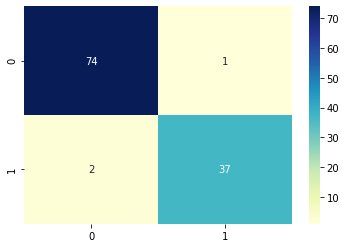

In [28]:
sns.heatmap(confusion_matrix(y_test,y_pred_rf),cmap="YlGnBu",annot=True, fmt="d")

In [29]:
#Without Hyper Parameters Tuning
#1-1,DesicionTree
#importing module
from sklearn.tree import DecisionTreeClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

#making the instance
model= DecisionTreeClassifier(criterion = 'entropy',random_state=1234)
#learning
model.fit(X_train,y_train)
#Prediction
prediction=model.predict(X_test)
#importing the metrics module
from sklearn import metrics
#evaluation(Accuracy)
print("Accuracy:",metrics.accuracy_score(prediction,y_test))
#print("Confusion Metrix:\n",metrics.confusion_matrix(prediction,y_test))

Accuracy: 0.9736842105263158


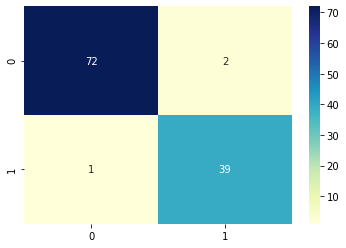

In [30]:
sns.heatmap(confusion_matrix(prediction,y_test),cmap="YlGnBu", annot=True, fmt="d")

In [31]:
from sklearn.neighbors import KNeighborsClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
knn = KNeighborsClassifier(n_neighbors = 5,)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
score = knn.score(X_test,y_test)
print("Score",score)
#print("CM",cm)
print("KNN acc",accuracy)

Score 0.9385964912280702
KNN acc 0.9385964912280702


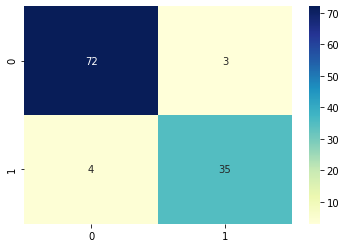

In [32]:
sns.heatmap(confusion_matrix(y_test,y_pred),cmap="YlGnBu", annot=True, fmt="d")

In [33]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import roc_auc_score
from sklearn import metrics
#from sklearn.metrics import confusion_matrix

lda = LDA()
lda.fit(X_train, y_train)
score = lda.score(X_test, y_test)
predections = lda.predict(X_test)
prob=lda.predict_proba(X_test)
auc = roc_auc_score(y_test, predections)

# fpr, tpr, thresholds = metrics.roc_curve(y_test, prob[:,1])
# plt.plot(fpr, tpr)
# # plt.show()
# # print ("AUC: ",auc)
print( "Accuracy= ",(score))


Accuracy=  0.9473684210526315


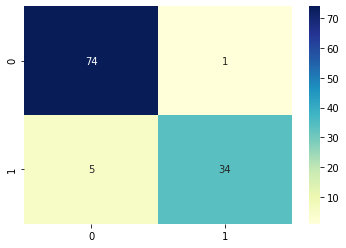

In [34]:
sns.heatmap(confusion_matrix(y_test, predections),cmap="YlGnBu", annot=True, fmt="d")

In [36]:
import xgboost
xg = xgboost.XGBClassifier(max_depth=3, n_estimators=400, learning_rate=0.05)
xg.fit(X_train, y_train)
y_pred_xg = xg.predict(X_test)
#accuracy = accuracy_score(y_test, y_pred_xg)
#print("Accuracy: %.2f" % (accuracy * 100.0))
print("XG boost accuracy : {:.2f}%".format(xg.score(X_test, y_test)*100))

[01:09:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XG boost accuracy : 94.74%


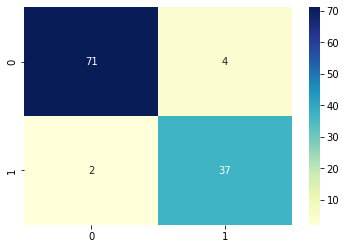

In [38]:
sns.heatmap(confusion_matrix(y_test, y_pred_xg),cmap="YlGnBu", annot=True, fmt="d")

In [52]:
from sklearn.ensemble import AdaBoostClassifier
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
# sample boyutuna bağlı olarak karar kütüklerinin kullanılması.
# Fazla oturmayı önlemeye çalışma
## AdaBoosted bir karar ağacı oluşturun ve uydurun
stump_clf =  DecisionTreeClassifier(random_state=42, max_depth=1)

param_grid = {
             "base_estimator__max_features": ['auto', 'sqrt', 'log2'],
             "n_estimators": list(range(1,500)),
             "learning_rate": np.linspace(0.01, 1, num=20),
            }
ada_clf = AdaBoostClassifier(base_estimator = stump_clf)

rand_ada = RandomizedSearchCV(ada_clf, param_grid, scoring = 'accuracy', n_iter=100, random_state=42)
rand_ada.fit(X,y)
print(rand_ada.best_score_)
print(rand_ada.best_params_)
print(rand_ada.best_estimator_)
#En iyi sonuç için parametre kombinasyonu çıkarımı yapılmıştır.Buna göre en yüksek sonucu elde edeceğiz.

0.9736531594472908
{'n_estimators': 306, 'learning_rate': 0.4268421052631579, 'base_estimator__max_features': 'auto'}
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         max_features='auto',
                                                         random_state=42),
                   learning_rate=0.4268421052631579, n_estimators=306)


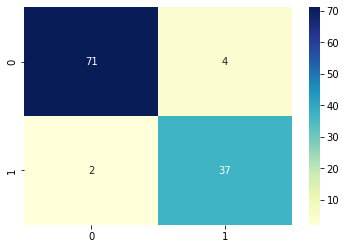

In [53]:
sns.heatmap(confusion_matrix(y_test, y_pred_xg),cmap="YlGnBu", annot=True, fmt="d")

In [48]:
from sklearn.ensemble import GradientBoostingClassifier

lr_list= [0.05,0.075,0.1,0.25,0.5,0.75,1] #Learning Rate

for learning_rate in lr_list:
    clf= GradientBoostingClassifier(n_estimators=20, 
                                    learning_rate=learning_rate,max_features=2,max_depth=2,random_state=0)
    clf.fit(X_train,y_train)

    print("Learning Rate :", learning_rate)
    print(" Accuracy rate of training ", clf.score(X_train,y_train))
    print("Accuracy score of the test :", clf.score(X_test,y_test))

Learning Rate : 0.05
 Accuracy rate of training  0.9736263736263736
Accuracy score of the test : 0.9473684210526315
Learning Rate : 0.075
 Accuracy rate of training  0.9736263736263736
Accuracy score of the test : 0.9385964912280702
Learning Rate : 0.1
 Accuracy rate of training  0.9824175824175824
Accuracy score of the test : 0.9473684210526315
Learning Rate : 0.25
 Accuracy rate of training  0.9934065934065934
Accuracy score of the test : 0.9649122807017544
Learning Rate : 0.5
 Accuracy rate of training  0.9956043956043956
Accuracy score of the test : 0.9649122807017544
Learning Rate : 0.75
 Accuracy rate of training  1.0
Accuracy score of the test : 0.956140350877193
Learning Rate : 1
 Accuracy rate of training  1.0
Accuracy score of the test : 0.9473684210526315


In [49]:
# En İyi Doğruluk oranı Öğrenme Oranında gözlemlenmiştir : 0.75
# Doğruluk oranı training: 1.0
# Doğruluk oranı test : 0.9415204678362573
clf_new= GradientBoostingClassifier(n_estimators=10,max_features=2,learning_rate=0.05,random_state=1)
clf_new.fit(X_test,y_test)
# Model üzerinde train doğrulanması
y_test_pred =clf_new.predict(X_test)
y_test_prob =clf_new.predict_proba(X_test)[:,1]

print("Accuracy Score of train", accuracy_score(y_test,y_test_pred))
#print("Accuracy Score of test", accuracy_score(y_test,y_test_pred))


Accuracy Score of train 0.9912280701754386


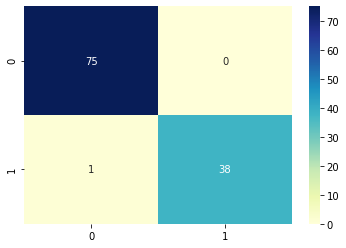

In [50]:
sns.heatmap(confusion_matrix(y_test,y_test_pred),cmap="YlGnBu", annot=True, fmt="d")

LogisticRegression: 0.945551 (0.041078)
KNN: 0.926253 (0.046232)
DecisionTreeClassifier: 0.926128 (0.035086)
NB: 0.931516 (0.042529)
AdaBoostClassifier: 0.966635 (0.016521)
[01:23:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:23:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:23:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was ch

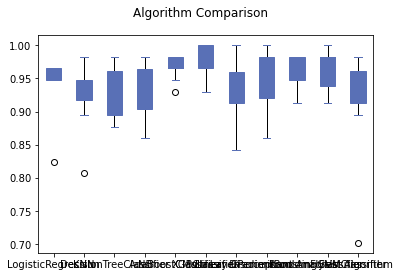

In [43]:
from sklearn import model_selection

seed = 7
# prepare models
models = []
models.append(('LogisticRegression', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('AdaBoostClassifier', AdaBoostClassifier()))
models.append(('XGBClassifier',xgboost.XGBClassifier()))
models.append(('Multi LayerPerceptron',MLPClassifier()))
models.append(('Linear Discriminant Analysis', LDA()))
models.append(('GradientBoostingClassifier', GradientBoostingClassifier()))
#models.append(('ANN',Sequential()))
models.append(('RandomForestClassifier', RandomForestClassifier()))
models.append(('SVM Algorithm ', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot ile algoritma karşılaştırması
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
#medianprops = dict(linestyle='-', linewidth=15, color='blue')
#medianprops = dict(linestyle='-', linewidth=10,color='green')
#plt.boxplot(results,medianprops=medianprops)

c = "#5970B6"
plt.boxplot(results, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            medianprops=dict(color=c),
            )
ax.set_xticklabels(names)

plt.show()